In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


## Overview

Should we trust online reviews and ratings websites like Fandango? Do different rating websites reflect similar ratings?

This data analysis is based on the article [Be Suspicious Of Online Movie Ratings, Especially Fandango’s].(http://fivethirtyeight.com/features/fandango-movies-ratings/)


----

### The Data

There are two csv files, one with Fandango Stars and Displayed Ratings, and the other with aggregate data for movie ratings from other sites, like Metacritic,IMDB, and Rotten Tomatoes.

#### all_sites_scores.csv

-----

`all_sites_scores.csv` contains every film that has a Rotten Tomatoes rating, a RT User rating, a Metacritic score, a Metacritic User score, and IMDb score, and at least 30 fan reviews on Fandango. The data from Fandango was pulled on Aug. 24, 2015.

----
----

#### fandango_scrape.csv

`fandango_scrape.csv` contains every film 538 pulled from Fandango.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Exploring Fandango's dataset

Let's check if our analysis agrees with the article's conclusion.

In [8]:
fandango = pd.read_csv("fandango_scrape.csv")
fandango.head()

,FILM,STARS,RATING,VOTES
0,Fifty Shades of Grey (2015),4.0,3.9,34846
1,Jurassic World (2015),4.5,4.5,34390
2,American Sniper (2015),5.0,4.8,34085
3,Furious 7 (2015),5.0,4.8,33538
4,Inside Out (2015),4.5,4.5,15749


In [9]:
fandango.describe()

,STARS,RATING,VOTES
count,504.000000,504.000000,504.000000
mean,3.558532,3.375794,1147.863095
std,1.563133,1.491223,3830.583136
min,0.000000,0.000000,0.000000
25%,3.500000,3.100000,3.000000
50%,4.000000,3.800000,18.500000
75%,4.500000,4.300000,189.750000
max,5.000000,5.000000,34846.000000


In [10]:
fandango.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FILM    504 non-null    object 
 1   STARS   504 non-null    float64
 2   RATING  504 non-null    float64
 3   VOTES   504 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 15.9+ KB


**Scatterplot showing the relationship between rating and votes.**

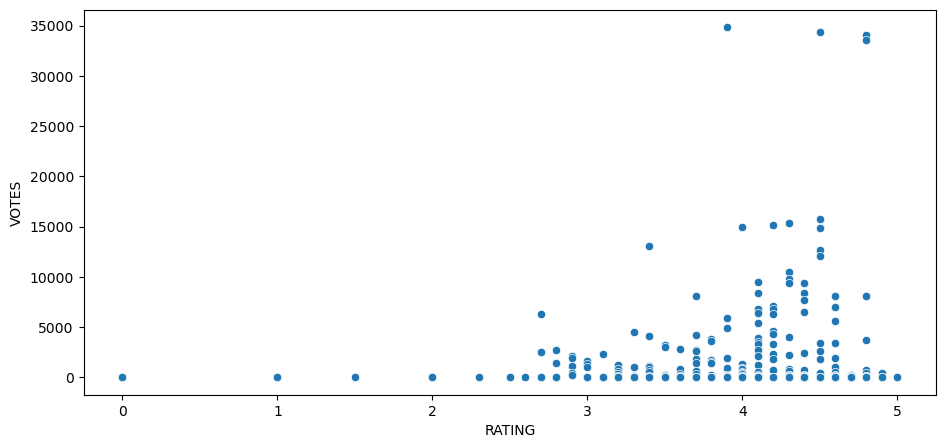

In [11]:
plt.figure(figsize=(11,5))
sns.scatterplot(data=fandango,x='RATING',y='VOTES');

**The correlation between the columns can be calculated with:**

In [12]:
fandango.corr()

,STARS,RATING,VOTES
STARS,1.000000,0.994696,0.164218
RATING,0.994696,1.000000,0.163764
VOTES,0.164218,0.163764,1.000000


**Getting the year from the film titles:**

In [13]:
fandango['YEAR'] = fandango['FILM'].apply(lambda title:title.split('(')[-1]).str.replace(')', '')

C:\Users\luigg\AppData\Local\Temp\ipykernel_14620\1351424323.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  fandango['YEAR'] = fandango['FILM'].apply(lambda title:title.split('(')[-1]).str.replace(')', '')


In [14]:
fandango['YEAR'].value_counts()

2015    478
2014     23
2016      1
1964      1
2012      1
Name: YEAR, dtype: int64

<AxesSubplot:xlabel='YEAR', ylabel='count'>

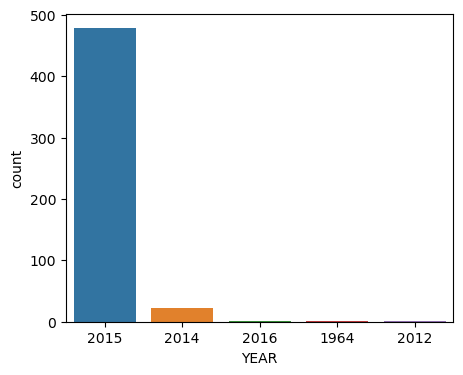

In [15]:
plt.figure(figsize=(5,4))
sns.countplot(data=fandango,x='YEAR')

**What are the 10 movies with the highest number of votes?**

In [16]:
fandango.nlargest(10,'VOTES')

,FILM,STARS,RATING,VOTES,YEAR
0,Fifty Shades of Grey (2015),4.0,3.9,34846,2015
1,Jurassic World (2015),4.5,4.5,34390,2015
2,American Sniper (2015),5.0,4.8,34085,2015
3,Furious 7 (2015),5.0,4.8,33538,2015
4,Inside Out (2015),4.5,4.5,15749,2015
5,The Hobbit: The Battle of the Five Armies (2014),4.5,4.3,15337,2014
6,Kingsman: The Secret Service (2015),4.5,4.2,15205,2015
7,Minions (2015),4.0,4.0,14998,2015
8,Avengers: Age of Ultron (2015),5.0,4.5,14846,2015
9,Into the Woods (2014),3.5,3.4,13055,2014


**Creating a DataFrame of only reviewed films by removing any films that have zero votes.**

In [17]:
reviewed = fandango[fandango['VOTES'] > 0]

**We can visualize the difference in STARS vs RATING distribution creating a KDE plot.**

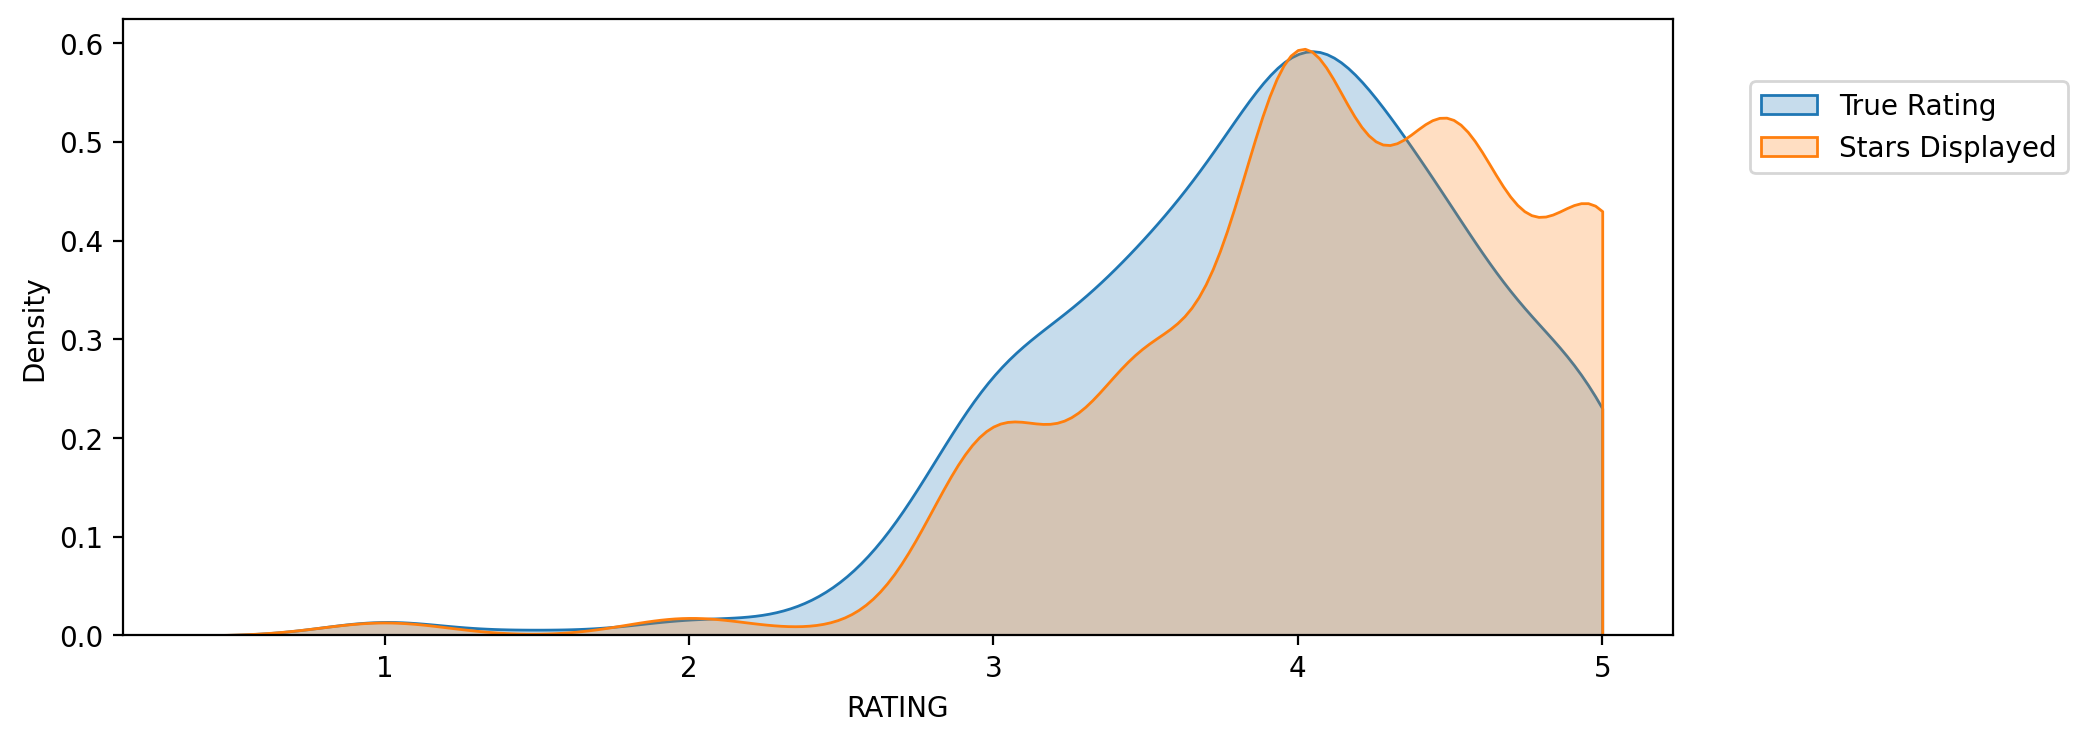

In [18]:
plt.figure(figsize=(10,4),dpi=200)
sns.kdeplot(data=reviewed,x='RATING',clip=[0,5],fill=True,label='True Rating')
sns.kdeplot(data=reviewed,x='STARS',clip=[0,5],fill=True,label='Stars Displayed')

plt.legend(loc=(1.05,0.75))

**Calculating this difference with STARS-RATING.**

In [19]:
reviewed['STARS_DIFF'] = round(reviewed['STARS'] - reviewed['RATING'],1)
reviewed

C:\Users\luigg\AppData\Local\Temp\ipykernel_14620\3369042728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewed['STARS_DIFF'] = round(reviewed['STARS'] - reviewed['RATING'],1)


,FILM,STARS,RATING,VOTES,YEAR,STARS_DIFF
0,Fifty Shades of Grey (2015),4.0,3.9,34846,2015,0.1
1,Jurassic World (2015),4.5,4.5,34390,2015,0.0
2,American Sniper (2015),5.0,4.8,34085,2015,0.2
3,Furious 7 (2015),5.0,4.8,33538,2015,0.2
4,Inside Out (2015),4.5,4.5,15749,2015,0.0
...,...,...,...,...,...,...
430,That Sugar Film (2015),5.0,5.0,1,2015,0.0
431,The Intern (2015),5.0,5.0,1,2015,0.0
432,The Park Bench (2015),5.0,5.0,1,2015,0.0
433,The Wanted 18 (2015),5.0,5.0,1,2015,0.0


**With a count plot we can see the number of times a certain difference occurs:**

<AxesSubplot:xlabel='STARS_DIFF', ylabel='count'>

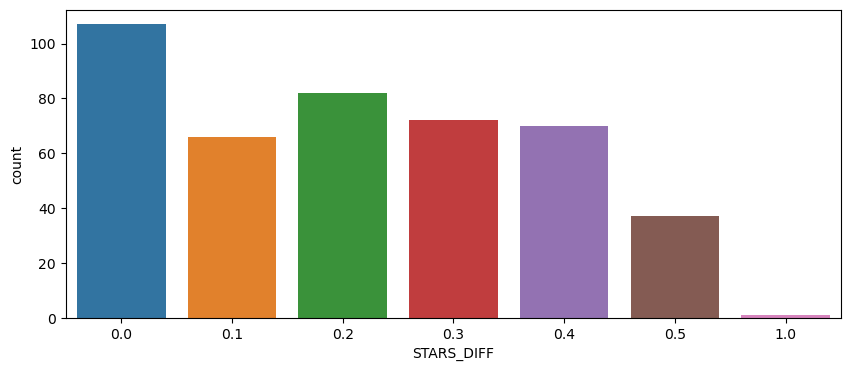

In [20]:
plt.figure(figsize=(10,4))
sns.countplot(data=reviewed,x='STARS_DIFF')

**From the plot we can visualize the biggest differences, one movie was displaying a 1 star difference than its true rating!**

In [21]:
reviewed[reviewed['STARS_DIFF']==1]

,FILM,STARS,RATING,VOTES,YEAR,STARS_DIFF
381,Turbo Kid (2015),5.0,4.0,2,2015,1.0


## Comparison between Fandango Ratings and Other Sites

Using the second dataset we can compare the scores from Fandango and other movies sites to see how they behave.


In [22]:
all_sites = pd.read_csv("all_sites_scores.csv")

**Exploring the DataFrame columns, info, description.**

In [23]:
all_sites.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,1330,271107
1,Cinderella (2015),85,80,67,7.5,7.1,249,65709
2,Ant-Man (2015),80,90,64,8.1,7.8,627,103660
3,Do You Believe? (2015),18,84,22,4.7,5.4,31,3136
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,88,19560


In [24]:
all_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Metacritic_user_vote_count  146 non-null    int64  
 7   IMDB_user_vote_count        146 non-null    int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 9.2+ KB


In [25]:
all_sites.describe()

,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,60.849315,63.876712,58.808219,6.519178,6.736986,185.705479,42846.205479
std,30.168799,20.024430,19.517389,1.510712,0.958736,316.606515,67406.509171
min,5.000000,20.000000,13.000000,2.400000,4.000000,4.000000,243.000000
25%,31.250000,50.000000,43.500000,5.700000,6.300000,33.250000,5627.000000
50%,63.500000,66.500000,59.000000,6.850000,6.900000,72.500000,19103.000000
75%,89.000000,81.000000,75.000000,7.500000,7.400000,168.500000,45185.750000
max,100.000000,94.000000,94.000000,9.600000,8.600000,2375.000000,334164.000000


In [26]:
all_sites.corr()

,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count
RottenTomatoes,1.000000,0.781440,0.957360,0.754296,0.779671,0.111325,0.107083
RottenTomatoes_User,0.781440,1.000000,0.690998,0.687132,0.895297,0.198320,0.221776
Metacritic,0.957360,0.690998,1.000000,0.723459,0.727298,0.138184,0.114507
Metacritic_User,0.754296,0.687132,0.723459,1.000000,0.756265,0.121478,0.112580
IMDB,0.779671,0.895297,0.727298,0.756265,1.000000,0.205573,0.230058
Metacritic_user_vote_count,0.111325,0.198320,0.138184,0.121478,0.205573,1.000000,0.880635
IMDB_user_vote_count,0.107083,0.221776,0.114507,0.112580,0.230058,0.880635,1.000000


### Rotten Tomatoes

Rotten Tomatoes has critics reviews (ratings published by official critics) and user reviews. 

**Scatterplot exploring the relationship between RT Critic reviews and RT User reviews:**

(0.0, 100.0)

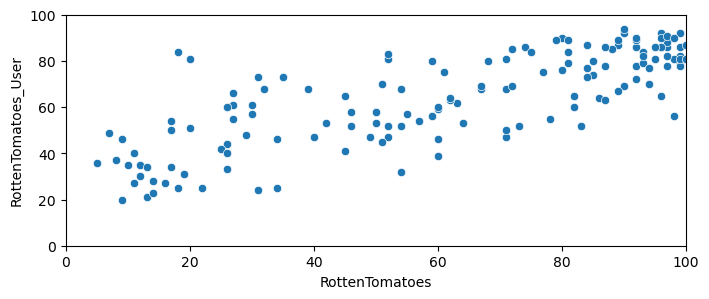

In [27]:
plt.figure(figsize=(8,3))
sns.scatterplot(data=all_sites,x='RottenTomatoes',y='RottenTomatoes_User')
plt.xlim(0,100)
plt.ylim(0,100)

**Creating a new column based off the difference between critics ratings and users ratings for Rotten Tomatoes:** 

In [28]:
all_sites['DIFF_RATING'] = all_sites['RottenTomatoes']-all_sites['RottenTomatoes_User']


**Calculating the Mean Absolute Difference between RT scores and RT User scores as described above.**

In [29]:
all_sites['DIFF_RATING'].abs().mean()


15.095890410958905

**Plotting the distribution of the differences between RT Critics Score and RT User Score. There should be negative values in this distribution plot. Feel free to use KDE or Histograms to display this distribution.**

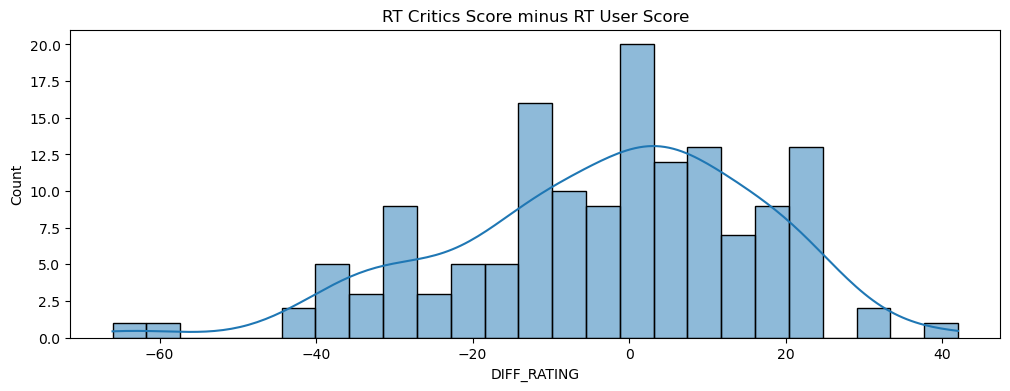

In [30]:
plt.figure(figsize=(12,4))
sns.histplot(data = all_sites,x='DIFF_RATING',kde=True,bins=25)
plt.title("RT Critics Score minus RT User Score");

**Creating a distribution showing the *absolute value* difference between Critics and Users on Rotten Tomatoes.**

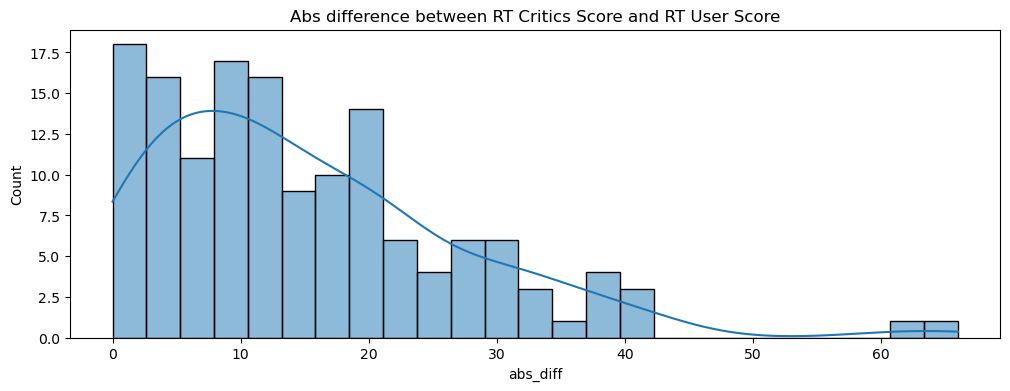

In [31]:
plt.figure(figsize=(12,4))
all_sites['abs_diff'] = all_sites['DIFF_RATING'].abs()
sns.histplot(data = all_sites,x='abs_diff',kde=True,bins=25)
plt.title("Abs difference between RT Critics Score and RT User Score");

**The top 5 movies users rated higher than critics on average:**

In [32]:
print("Users Love but Critics Hate")
all_sites[['FILM','DIFF_RATING']].nsmallest(5,'DIFF_RATING')

Users Love but Critics Hate


,FILM,DIFF_RATING
3,Do You Believe? (2015),-66
85,Little Boy (2015),-61
105,Hitman: Agent 47 (2015),-42
134,The Longest Ride (2015),-42
125,The Wedding Ringer (2015),-39


**The top 5 movies critics scores higher than users on average.**

In [33]:
print("Critics Love but Users Hate")
all_sites[['FILM','DIFF_RATING']].nlargest(5,'DIFF_RATING')

Critics Love but Users Hate


,FILM,DIFF_RATING
69,Mr. Turner (2014),42
112,It Follows (2015),31
115,While We're Young (2015),31
37,Welcome to Me (2015),24
40,I'll See You In My Dreams (2015),24


## MetaCritic

Metacritic also shows an average user rating versus their official displayed rating.

**Scatterplot of the Metacritic Rating versus the Metacritic User rating:**

<AxesSubplot:xlabel='Metacritic', ylabel='Metacritic_User'>

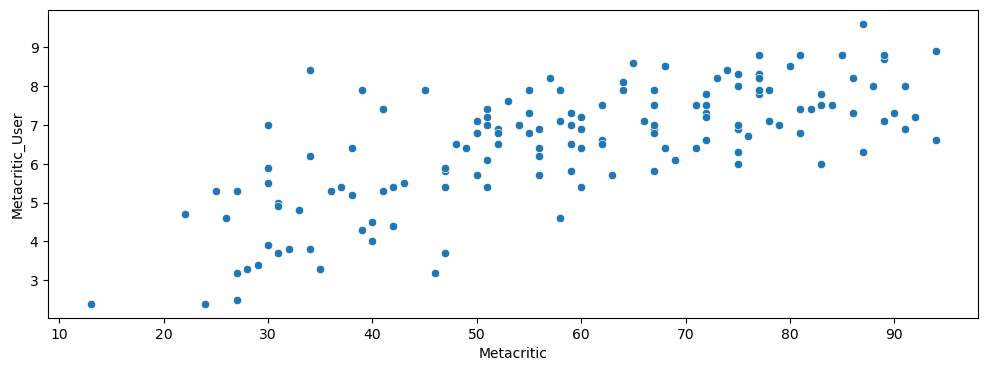

In [34]:
plt.figure(figsize=(12,4))
sns.scatterplot(data=all_sites,x='Metacritic',y='Metacritic_User')

## Fandago Scores vs. All Sites
**Combining the Fandango Table with the All Sites table. Not every movie in the Fandango table is in the All Sites table, since some Fandango movies have very little or no reviews.**

In [35]:
df = pd.merge(fandango,all_sites, how='inner', on="FILM")

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 144
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        145 non-null    object 
 1   STARS                       145 non-null    float64
 2   RATING                      145 non-null    float64
 3   VOTES                       145 non-null    int64  
 4   YEAR                        145 non-null    object 
 5   RottenTomatoes              145 non-null    int64  
 6   RottenTomatoes_User         145 non-null    int64  
 7   Metacritic                  145 non-null    int64  
 8   Metacritic_User             145 non-null    float64
 9   IMDB                        145 non-null    float64
 10  Metacritic_user_vote_count  145 non-null    int64  
 11  IMDB_user_vote_count        145 non-null    int64  
 12  DIFF_RATING                 145 non-null    int64  
 13  abs_diff                    145 non

RT,Metacritic, and IMDB don't use a score between 0-5 stars like Fandango does. So we need to *normalize* these values so they all fall between 0-5 stars and the relationship between reviews stays the same.

**Creating new normalized columns for all ratings so they match up within the 0-5 star range shown on Fandango.**

In [37]:
df['RT_Norm'] = np.round(df['RottenTomatoes']/20,1)
df['RTU_Norm'] =  np.round(df['RottenTomatoes_User']/20,1)

In [38]:
df['Meta_Norm'] =  np.round(df['Metacritic']/20,1)
df['Meta_U_Norm'] =  np.round(df['Metacritic_User']/2,1)

In [39]:
df['IMDB_Norm'] = np.round(df['IMDB']/2,1)
df.head()

,FILM,STARS,RATING,VOTES,YEAR,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count,DIFF_RATING,abs_diff,RT_Norm,RTU_Norm,Meta_Norm,Meta_U_Norm,IMDB_Norm
0,Fifty Shades of Grey (2015),4.0,3.9,34846,2015,25,42,46,3.2,4.2,778,179506,-17,17,1.2,2.1,2.3,1.6,2.1
1,Jurassic World (2015),4.5,4.5,34390,2015,71,81,59,7.0,7.3,1281,241807,-10,10,3.6,4.0,3.0,3.5,3.6
2,American Sniper (2015),5.0,4.8,34085,2015,72,85,72,6.6,7.4,850,251856,-13,13,3.6,4.2,3.6,3.3,3.7
3,Furious 7 (2015),5.0,4.8,33538,2015,81,84,67,6.8,7.4,764,207211,-3,3,4.0,4.2,3.4,3.4,3.7
4,Inside Out (2015),4.5,4.5,15749,2015,98,90,94,8.9,8.6,807,96252,8,8,4.9,4.5,4.7,4.4,4.3


**Creating a norm_scores DataFrame that only contains the normalized ratings.**

In [40]:
norm_scores = df[['STARS','RATING','RT_Norm','RTU_Norm','Meta_Norm','Meta_U_Norm','IMDB_Norm']]


In [41]:
norm_scores.head()

,STARS,RATING,RT_Norm,RTU_Norm,Meta_Norm,Meta_U_Norm,IMDB_Norm
0,4.0,3.9,1.2,2.1,2.3,1.6,2.1
1,4.5,4.5,3.6,4.0,3.0,3.5,3.6
2,5.0,4.8,3.6,4.2,3.6,3.3,3.7
3,5.0,4.8,4.0,4.2,3.4,3.4,3.7
4,4.5,4.5,4.9,4.5,4.7,4.4,4.3


**Now we can create a plot comparing the distributions of normalized ratings across all sites and see if Fandago's has a discrepancy in the ratings.**

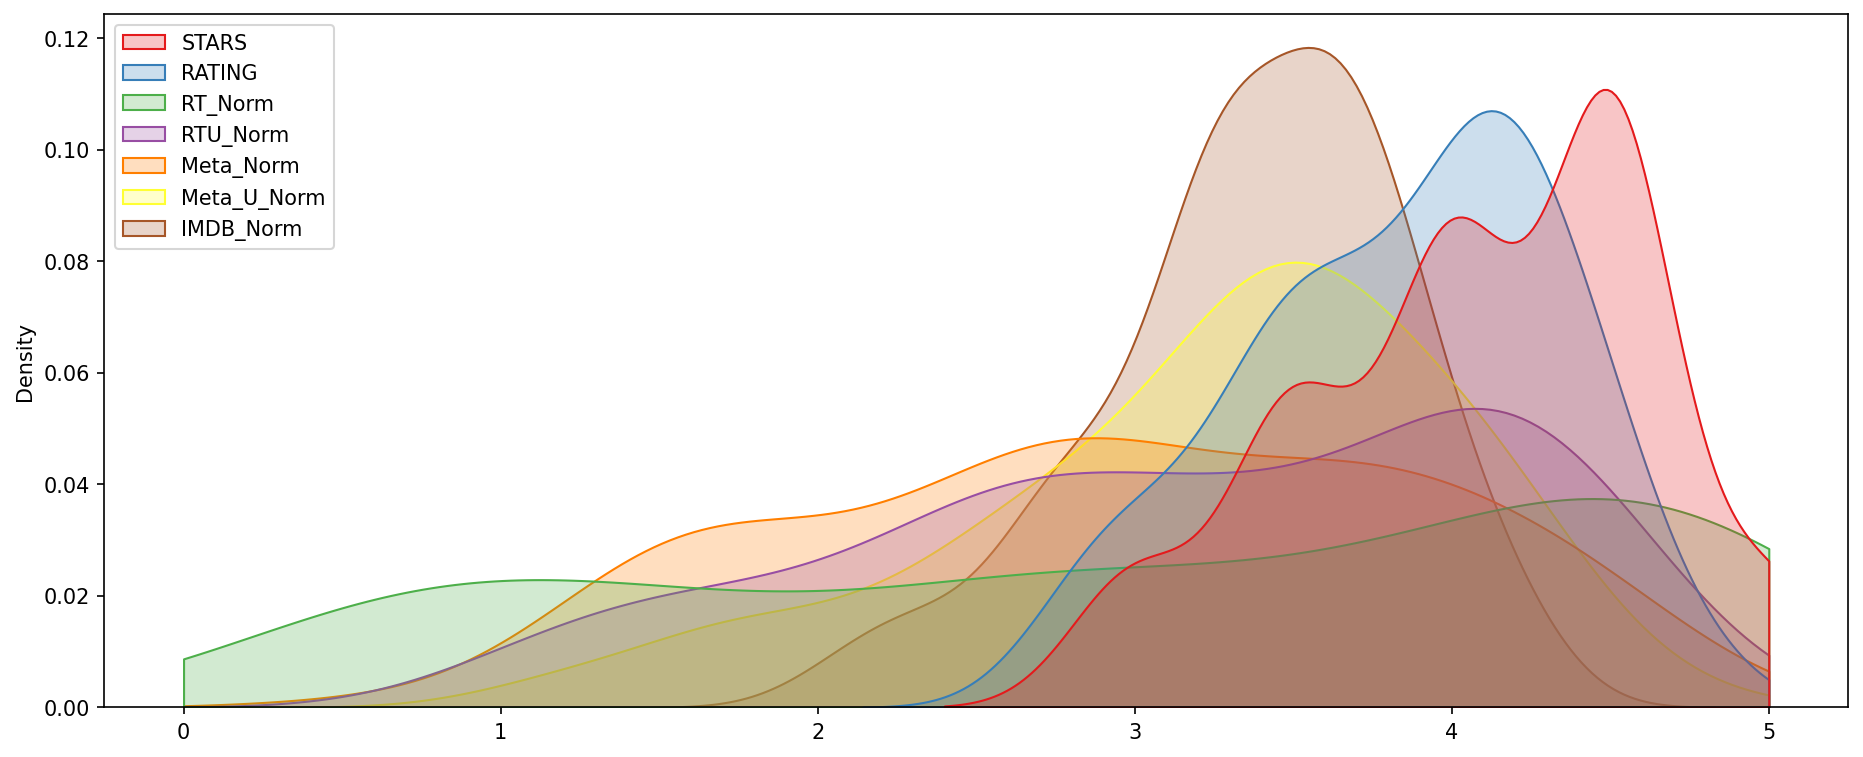

In [42]:
plt.figure(figsize=(15,6),dpi=150)
kdes = sns.kdeplot(data=norm_scores,clip=[0,5],fill=True,palette='Set1')
sns.move_legend(kdes, "upper left")

**We can clearly see that Fandango has an uneven distribution. We can also see that RT critics have the most uniform distribution.**

### How are the worst movies rated across all platforms?

**Creating a clustermap visualization of all normalized scores. Note the differences in ratings, highly rated movies should be clustered together versus poorly rated movies.**

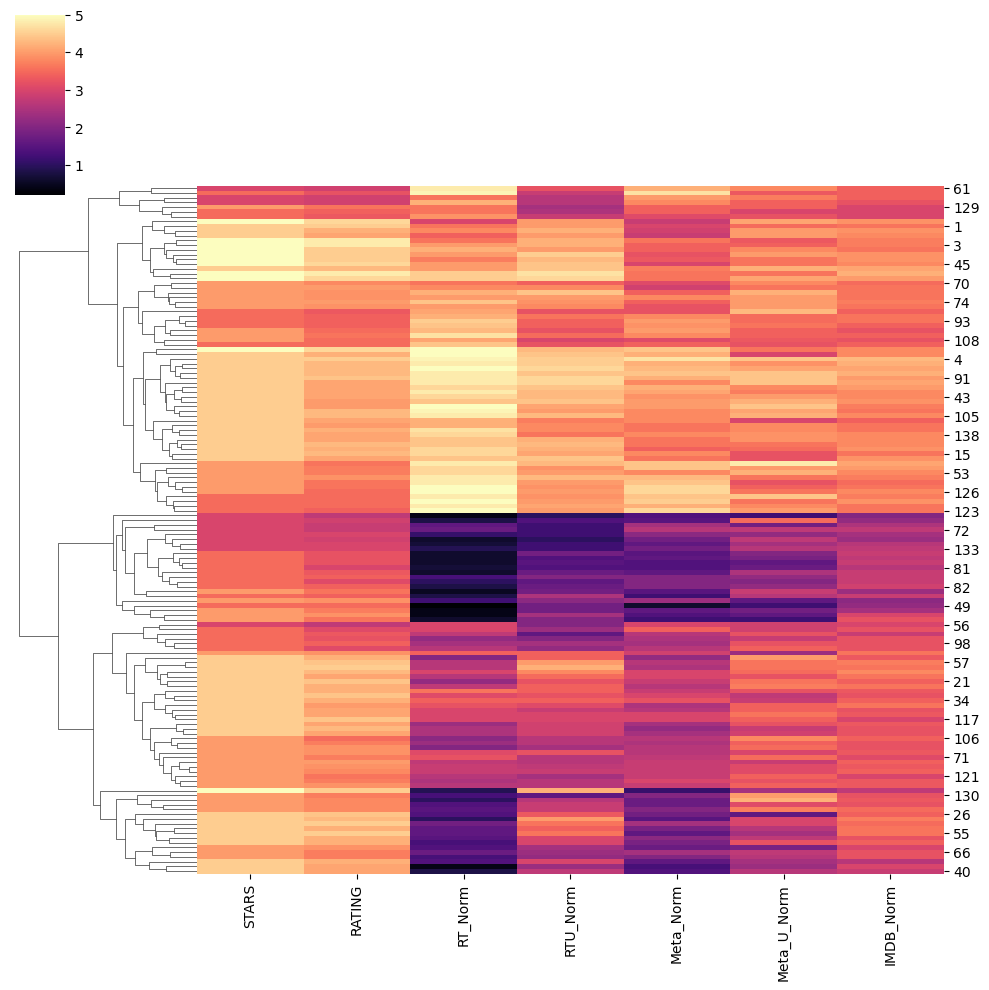

In [43]:
sns.clustermap(norm_scores,cmap='magma',col_cluster=False);

**By the clustermap we can visualize that Fandango is rating movies much higher than other sites. This can be confirmed looking at the correlation in the normalized ratings:**

In [44]:
norm_scores.corr()

,STARS,RATING,RT_Norm,RTU_Norm,Meta_Norm,Meta_U_Norm,IMDB_Norm
STARS,1.000000,0.959869,0.291971,0.701676,0.176795,0.336772,0.584997
RATING,0.959869,1.000000,0.285493,0.720463,0.171162,0.334292,0.597192
RT_Norm,0.291971,0.285493,1.000000,0.781465,0.956184,0.750757,0.773713
RTU_Norm,0.701676,0.720463,0.781465,1.000000,0.688321,0.690990,0.890570
Meta_Norm,0.176795,0.171162,0.956184,0.688321,1.000000,0.714845,0.719655
Meta_U_Norm,0.336772,0.334292,0.750757,0.690990,0.714845,1.000000,0.747373
IMDB_Norm,0.584997,0.597192,0.773713,0.890570,0.719655,0.747373,1.000000


**The RATING and STARS correlation with the other ratings are significant lower.**